In [4]:
import sys
sys.path.append('..')

from src.config import load_config
from src.load_data import load_data, get_class_dist
from src.splits import save_splits, load_splits_meta
from src.transforms import get_transforms, get_base_transforms, compute_dataset_stats, denormalize, tensor_to_image
import matplotlib.pyplot as plt
import numpy as np
import torch

In [5]:
config = load_config()

train_dataset, val_dataset, test_dataset = load_data(split_data=True)
total = len(train_dataset) + len(val_dataset) + len(test_dataset)

print(f"\n{'='*50}")
print(f"Total Images per Split:")
print(f"{'='*50}")
print(f"Train: {len(train_dataset):4d} images ({len(train_dataset) / total * 100:.2f}%)")
print(f"Val:   {len(val_dataset):4d} images ({len(val_dataset) / total * 100:.2f}%)")
print(f"Test:  {len(test_dataset):4d} images ({len(test_dataset) / total * 100:.2f}%)")
print(f"Total: {total:4d} images")
print(f"{'='*50}")


Total Images per Split:
Train: 3537 images (69.98%)
Val:    758 images (15.00%)
Test:   759 images (15.02%)
Total: 5054 images


In [6]:
train_dist = get_class_dist(train_dataset)
val_dist = get_class_dist(val_dataset)
test_dist = get_class_dist(test_dataset)

class_names = list(train_dist.keys())

print(f"\n{'='*80}")
print(f"Class Balance Verification")
print(f"{'='*80}")
print(f"{'Class':<12} | {'Train':>15} | {'Val':>15} | {'Test':>15}")
print(f"{'-'*12}-+-{'-'*15}-+-{'-'*15}-+-{'-'*15}")

for class_name in class_names:
    train_count = train_dist[class_name]
    val_count = val_dist[class_name]
    test_count = test_dist[class_name]
    
    train_pct = (train_count / len(train_dataset)) * 100
    val_pct = (val_count / len(val_dataset)) * 100
    test_pct = (test_count / len(test_dataset)) * 100
    
    print(f"{class_name:<12} | {train_count:4d} ({train_pct:5.1f}%) | {val_count:4d} ({val_pct:5.1f}%) | {test_count:4d} ({test_pct:5.1f}%)")

print(f"{'-'*12}-+-{'-'*15}-+-{'-'*15}-+-{'-'*15}")
print(f"{'Total':<12} | {len(train_dataset):4d} (100.0%) | {len(val_dataset):4d} (100.0%) | {len(test_dataset):4d} (100.0%)")
print(f"{'='*80}")


Class Balance Verification
Class        |           Train |             Val |            Test
-------------+-----------------+-----------------+----------------
cardboard    |  580 ( 16.4%) |  110 ( 14.5%) |  116 ( 15.3%)
glass        |  705 ( 19.9%) |  143 ( 18.9%) |  154 ( 20.3%)
metal        |  585 ( 16.5%) |  116 ( 15.3%) |  119 ( 15.7%)
paper        |  821 ( 23.2%) |  187 ( 24.7%) |  180 ( 23.7%)
plastic      |  647 ( 18.3%) |  166 ( 21.9%) |  151 ( 19.9%)
trash        |  199 (  5.6%) |   36 (  4.7%) |   39 (  5.1%)
-------------+-----------------+-----------------+----------------
Total        | 3537 (100.0%) |  758 (100.0%) |  759 (100.0%)


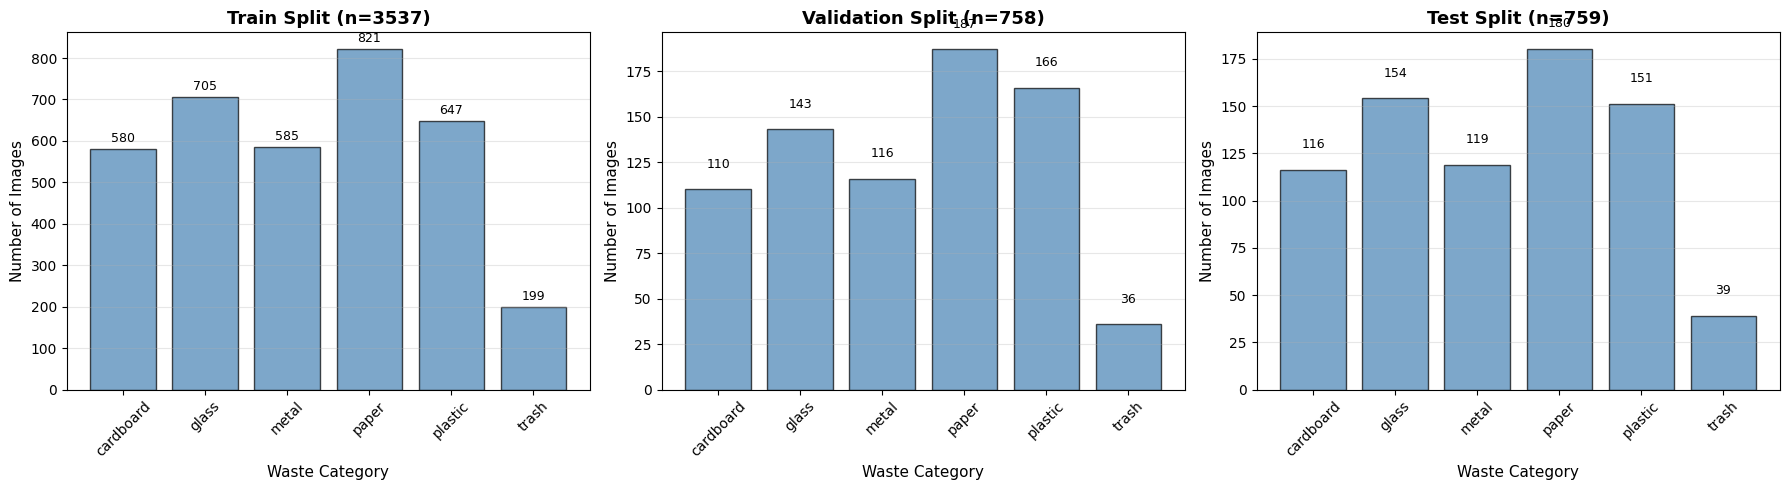

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

splits = [('Train', train_dist, len(train_dataset)), 
          ('Validation', val_dist, len(val_dataset)), 
          ('Test', test_dist, len(test_dataset))]

for ax, (split_name, dist, total) in zip(axes, splits):
    classes = list(dist.keys())
    counts = list(dist.values())
    
    bars = ax.bar(classes, counts, color='steelblue', edgecolor='black', alpha=0.7)
    ax.set_xlabel('Waste Category', fontsize=11)
    ax.set_ylabel('Number of Images', fontsize=11)
    ax.set_title(f'{split_name} Split (n={total})', fontsize=13, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    for i, (cls, count) in enumerate(zip(classes, counts)):
        ax.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [8]:
print("Computing TrashNet-specific normalization statistics...\n")
full_dataset = load_data(split_data=False)

trashnet_stats = compute_dataset_stats(full_dataset, config, num_samples=1000)

imagenet_stats = {
    'mean': config['normalization']['mean'],
    'std': config['normalization']['std']
}

print(f"\n{'='*70}")
print(f"Normalization Statistics Comparison")
print(f"{'='*70}")
print(f"\n{'Dataset':<15} | {'R Mean':>10} | {'G Mean':>10} | {'B Mean':>10}")
print(f"{'-'*15}-+-{'-'*10}-+-{'-'*10}-+-{'-'*10}")
print(f"{'ImageNet':<15} | {imagenet_stats['mean'][0]:>10.4f} | {imagenet_stats['mean'][1]:>10.4f} | {imagenet_stats['mean'][2]:>10.4f}")
print(f"{'TrashNet':<15} | {trashnet_stats['mean'][0]:>10.4f} | {trashnet_stats['mean'][1]:>10.4f} | {trashnet_stats['mean'][2]:>10.4f}")

print(f"\n{'Dataset':<15} | {'R Std':>10} | {'G Std':>10} | {'B Std':>10}")
print(f"{'-'*15}-+-{'-'*10}-+-{'-'*10}-+-{'-'*10}")
print(f"{'ImageNet':<15} | {imagenet_stats['std'][0]:>10.4f} | {imagenet_stats['std'][1]:>10.4f} | {imagenet_stats['std'][2]:>10.4f}")
print(f"{'TrashNet':<15} | {trashnet_stats['std'][0]:>10.4f} | {trashnet_stats['std'][1]:>10.4f} | {trashnet_stats['std'][2]:>10.4f}")
print(f"{'='*70}")

print(f"\nNote: Using ImageNet stats is recommended for transfer learning with pretrained models.")

Computing TrashNet-specific normalization statistics...

Computing dataset statistics...
Processing 1000 images...
  Processed 500/1000 images
  Processed 1000/1000 images

Dataset Statistics:
  Mean: [0.6768453121185303, 0.6304212808609009, 0.5802809000015259]
  Std:  [0.18257321417331696, 0.18208937346935272, 0.1952831894159317]

Normalization Statistics Comparison

Dataset         |     R Mean |     G Mean |     B Mean
----------------+------------+------------+-----------
ImageNet        |     0.4850 |     0.4560 |     0.4060
TrashNet        |     0.6768 |     0.6304 |     0.5803

Dataset         |      R Std |      G Std |      B Std
----------------+------------+------------+-----------
ImageNet        |     0.2290 |     0.2240 |     0.2250
TrashNet        |     0.1826 |     0.1821 |     0.1953

Note: Using ImageNet stats is recommended for transfer learning with pretrained models.


## Dataset Normalization Statistics

Compare ImageNet normalization statistics with TrashNet-specific statistics.

Sample images from each class:



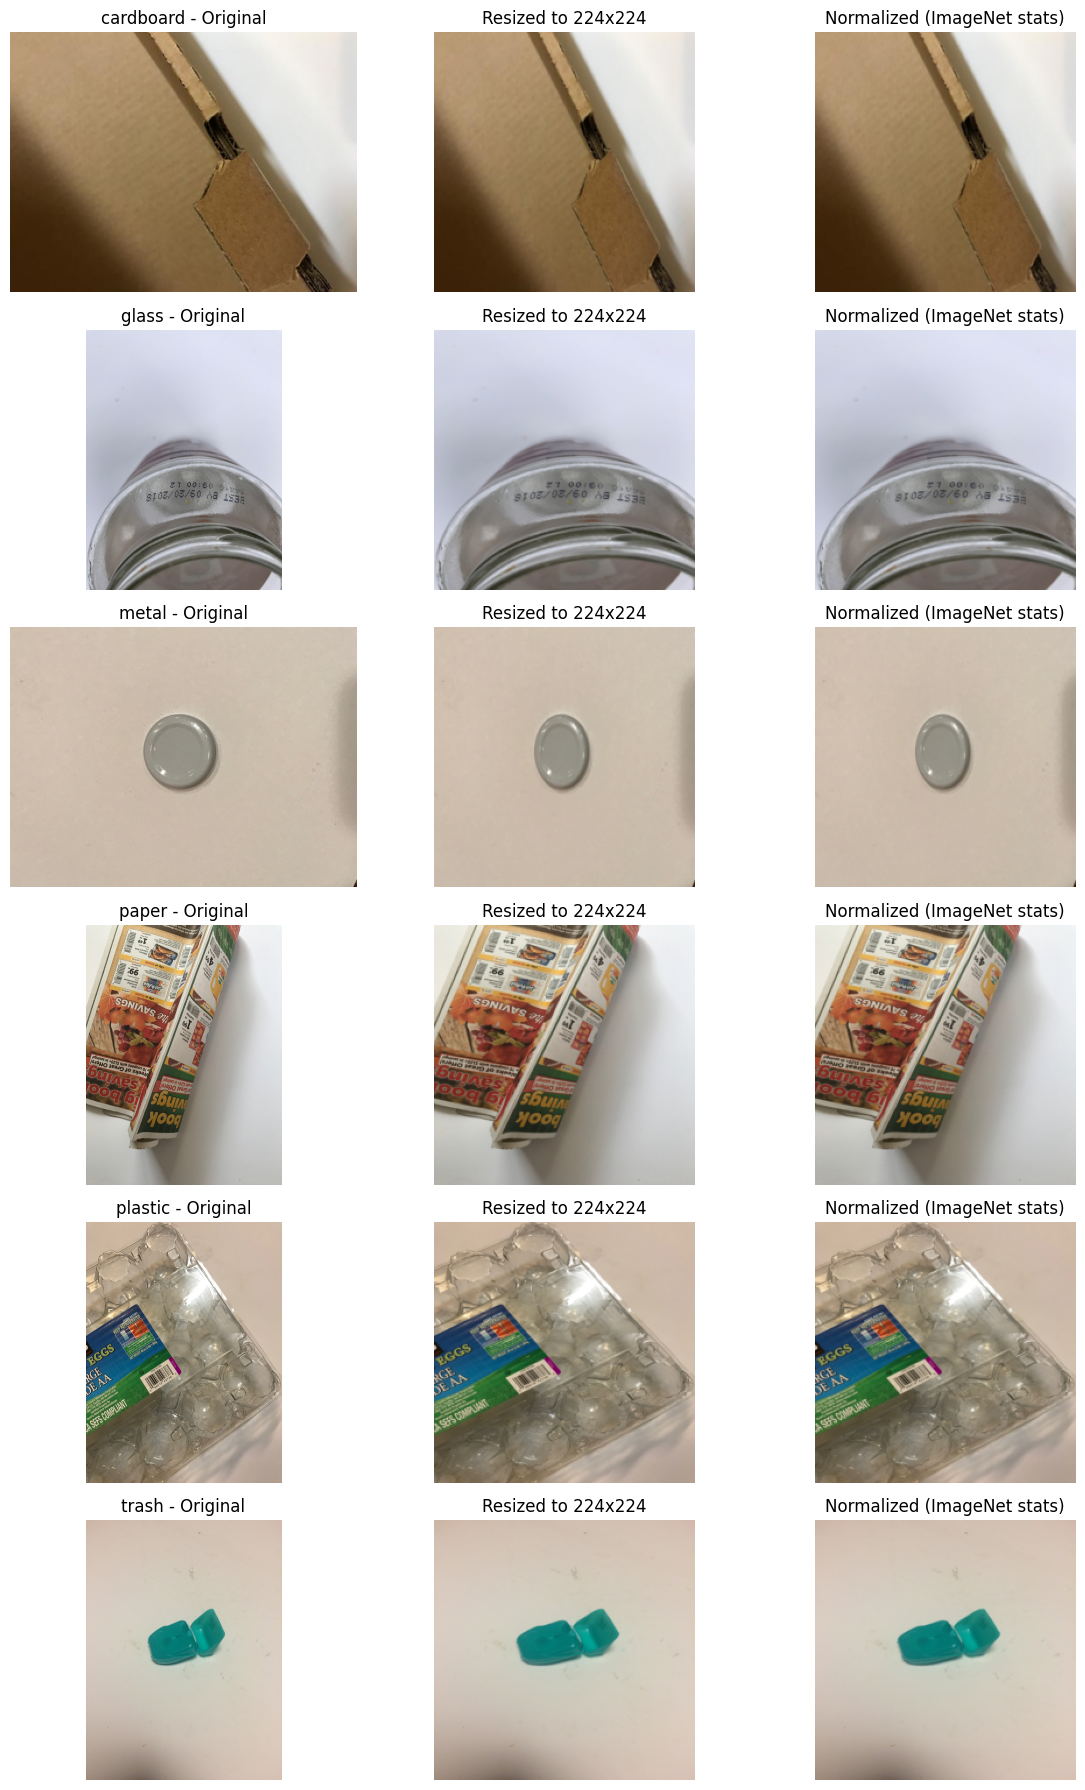

In [10]:
print("Sample images from each class:\n")

fig, axes = plt.subplots(len(class_names), 3, figsize=(12, len(class_names) * 3))

base_transform = get_base_transforms(config)
val_transform = get_transforms(config, split='val')

for idx, class_name in enumerate(class_names):
    label_names = train_dataset.features['label'].names
    for i in range(len(train_dataset)):
        item = train_dataset[i]
        image = item['image']
        label = item['label']
        if label_names[label] == class_name:
            axes[idx, 0].imshow(image)
            axes[idx, 0].set_title(f'{class_name} - Original')
            axes[idx, 0].axis('off')
            
            resized = base_transform(image)
            axes[idx, 1].imshow(resized.permute(1, 2, 0))
            axes[idx, 1].set_title(f'Resized to {config["data"]["image_size"]}x{config["data"]["image_size"]}')
            axes[idx, 1].axis('off')
            
            preprocessed = val_transform(image)
            denorm = denormalize(preprocessed, config)
            axes[idx, 2].imshow(denorm.permute(1, 2, 0))
            axes[idx, 2].set_title('Normalized (ImageNet stats)')
            axes[idx, 2].axis('off')
            
            break

plt.tight_layout()
plt.show()

In [11]:
splits_info = save_splits(train_dataset, val_dataset, test_dataset, config)

print(f"\n✓ Splits saved to {config['paths']['splits_dir']}")
print(f"\nFiles created:")
print(f"  - train_indices.txt ({splits_info['train_size']} samples)")
print(f"  - val_indices.txt ({splits_info['val_size']} samples)")
print(f"  - test_indices.txt ({splits_info['test_size']} samples)")
print(f"  - splits.json (complete metadata)")


✓ Splits saved to data/splits

Files created:
  - train_indices.txt (3537 samples)
  - val_indices.txt (758 samples)
  - test_indices.txt (759 samples)
  - splits.json (complete metadata)


## Final Summary

In [ ]:
total_images = splits_info['total']

print(f"\n{'='*60}")
print(f"FINAL SPLIT SUMMARY")
print(f"{'='*60}")
print(f"\nDataset: {splits_info['dataset_name']}")
print(f"Random Seed: {splits_info['seed']}")
print(f"\nSplit Distribution:")
print(f"  Training:   {splits_info['train_size']:4d} images ({splits_info['train_size']/total_images*100:.1f}%)")
print(f"  Validation: {splits_info['val_size']:4d} images ({splits_info['val_size']/total_images*100:.1f}%)")
print(f"  Test:       {splits_info['test_size']:4d} images ({splits_info['test_size']/total_images*100:.1f}%)")
print(f"  Total:      {total_images:4d} images")
print(f"\nNumber of Classes: {config['data']['num_classes']}")
print(f"Classes: {', '.join(config['data']['classes'])}")
print(f"\nSplit files saved to: {config['paths']['splits_dir']}")
print(f"{'='*60}")


FINAL SPLIT SUMMARY

Dataset: garythung/trashnet
Random Seed: 42

Split Distribution:
  Training:   3537 images (70.0%)
  Validation:  758 images (15.0%)
  Test:        759 images (15.0%)
  Total:      5054 images

Number of Classes: 6
Classes: cardboard, glass, metal, paper, plastic, trash

Split files saved to: data/splits
